In [8]:
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF, MiniBatchNMF

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
df = pd.read_csv('/content/drive/MyDrive/lg_aimers/data/train.csv')
df.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


In [12]:
df.shape

(59299, 29)

In [13]:
raw_corpus = df['expected_timeline']
raw_corpus = raw_corpus.dropna().reset_index(drop=True)
raw_corpus

0         less than 3 months
1         less than 3 months
2         less than 3 months
3         less than 3 months
4         less than 3 months
                ...         
28431    3 months ~ 6 months
28432      9 months ~ 1 year
28433     less than 3 months
28434       more than a year
28435     less than 3 months
Name: expected_timeline, Length: 28436, dtype: object

In [14]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(raw_corpus)

In [15]:
tfidf.shape

(28436, 811)

In [16]:
# Number of top words you want to see for each document
k = 10

# Get feature names (the vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Prepare to store the top words and their corresponding scores
top_words_per_document = []

# Iterate over each row of the tfidf matrix (each document)
for row in range(tfidf.shape[0]):
    # Get the indices of the top k values in the row
    top_k_indices = np.argsort(tfidf[row].toarray().flatten())[-k:]

    # Get the corresponding top k words and their tfidf scores
    top_words_scores = [(feature_names[index], tfidf[row, index]) for index in top_k_indices]

    # Sort the top words with scores based on scores
    top_words_scores.sort(key=lambda x: x[1], reverse=True)

    # Add the top words with their scores to the list
    top_words_per_document.append(top_words_scores)

# Now top_words_per_document contains the top-k words with their weights for each document
# If you want to print the results for the first document as an example:
print("Top 10 words for the first document:", top_words_per_document[0])

Top 10 words for the first document: [('less', 0.6476025295084672), ('than', 0.577980290235187), ('months', 0.4965377607734218), ('dont', 0.0), ('dot', 0.0), ('driving', 0.0), ('drop', 0.0), ('dropped', 0.0), ('disti', 0.0), ('última', 0.0)]


In [17]:
tfidf.shape

(28436, 811)

top-3 내에서 사실상 대부분의 weight가 결정됨.

In [18]:
# Number of top words you want to see for each document
k = 3

# Get feature names (the vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Prepare to store the top words and their corresponding scores
top_words_per_document = []

# Iterate over each row of the tfidf matrix (each document)
for row in range(tfidf.shape[0]):
    # Get the indices of the top k values in the row
    top_k_indices = np.argsort(tfidf[row].toarray().flatten())[-k:]

    # Get the corresponding top k words and their tfidf scores
    top_words_scores = [(feature_names[index], tfidf[row, index]) for index in top_k_indices]

    # Sort the top words with scores based on scores
    top_words_scores.sort(key=lambda x: x[1], reverse=True)

    # Add the top words with their scores to the list
    top_words_per_document.append(top_words_scores)

# Now top_words_per_document contains the top-k words with their weights for each document
# If you want to print the results for the first document as an example:
print("Top 10 words for the first document:", top_words_per_document[0])

Top 10 words for the first document: [('less', 0.6476025295084672), ('than', 0.577980290235187), ('months', 0.4965377607734218)]


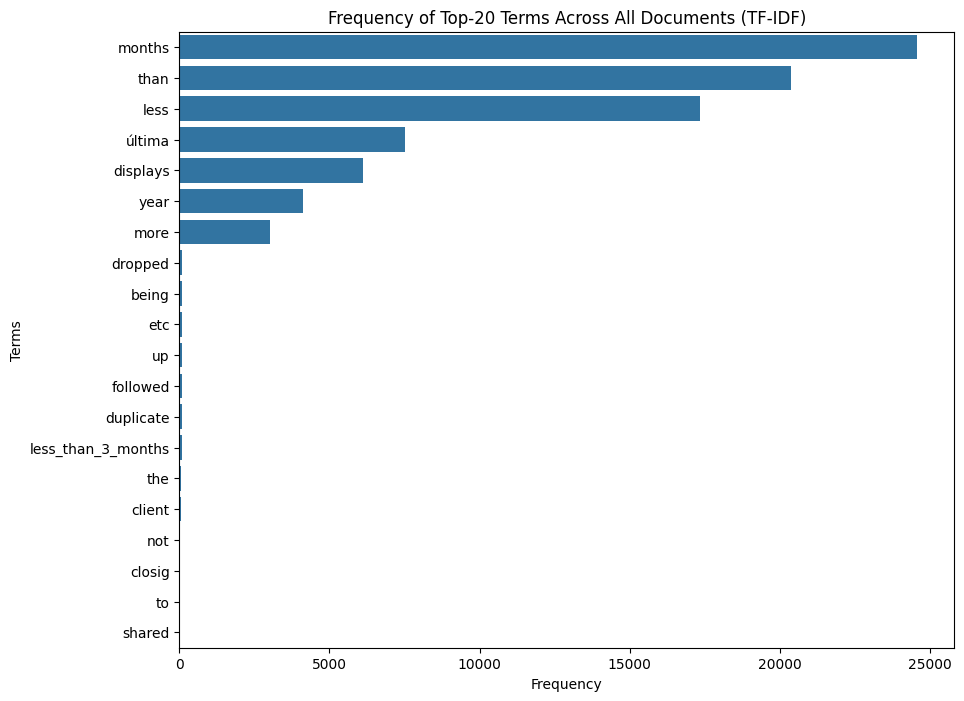

In [19]:
# Assuming top_words_per_document contains your top words data as shown in your message
# Flatten the list to count each term's frequency across all documents
all_top_words = [word for sublist in top_words_per_document for (word, _) in sublist]

# Create a DataFrame from the flattened list
df_words = pd.DataFrame(all_top_words, columns=['Word'])

# Get the counts of each word and keep the top 20
plot_top_k = 20
top_k_words = df_words['Word'].value_counts().nlargest(plot_top_k).index

# Filter the DataFrame to include only the top 20 words
df_top_k_words = df_words[df_words['Word'].isin(top_k_words)]

# Plotting
plt.figure(figsize=(10, 8))
sns.countplot(y='Word', data=df_top_k_words, order=df_words['Word'].value_counts().nlargest(plot_top_k).index)
plt.title(f'Frequency of Top-{plot_top_k} Terms Across All Documents (TF-IDF)')
plt.xlabel('Frequency')
plt.ylabel('Terms')
plt.show()

In [20]:
nmf = NMF(
    n_components=10,
    random_state=1,
    init='nndsvda',
    beta_loss="frobenius",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)

In [21]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

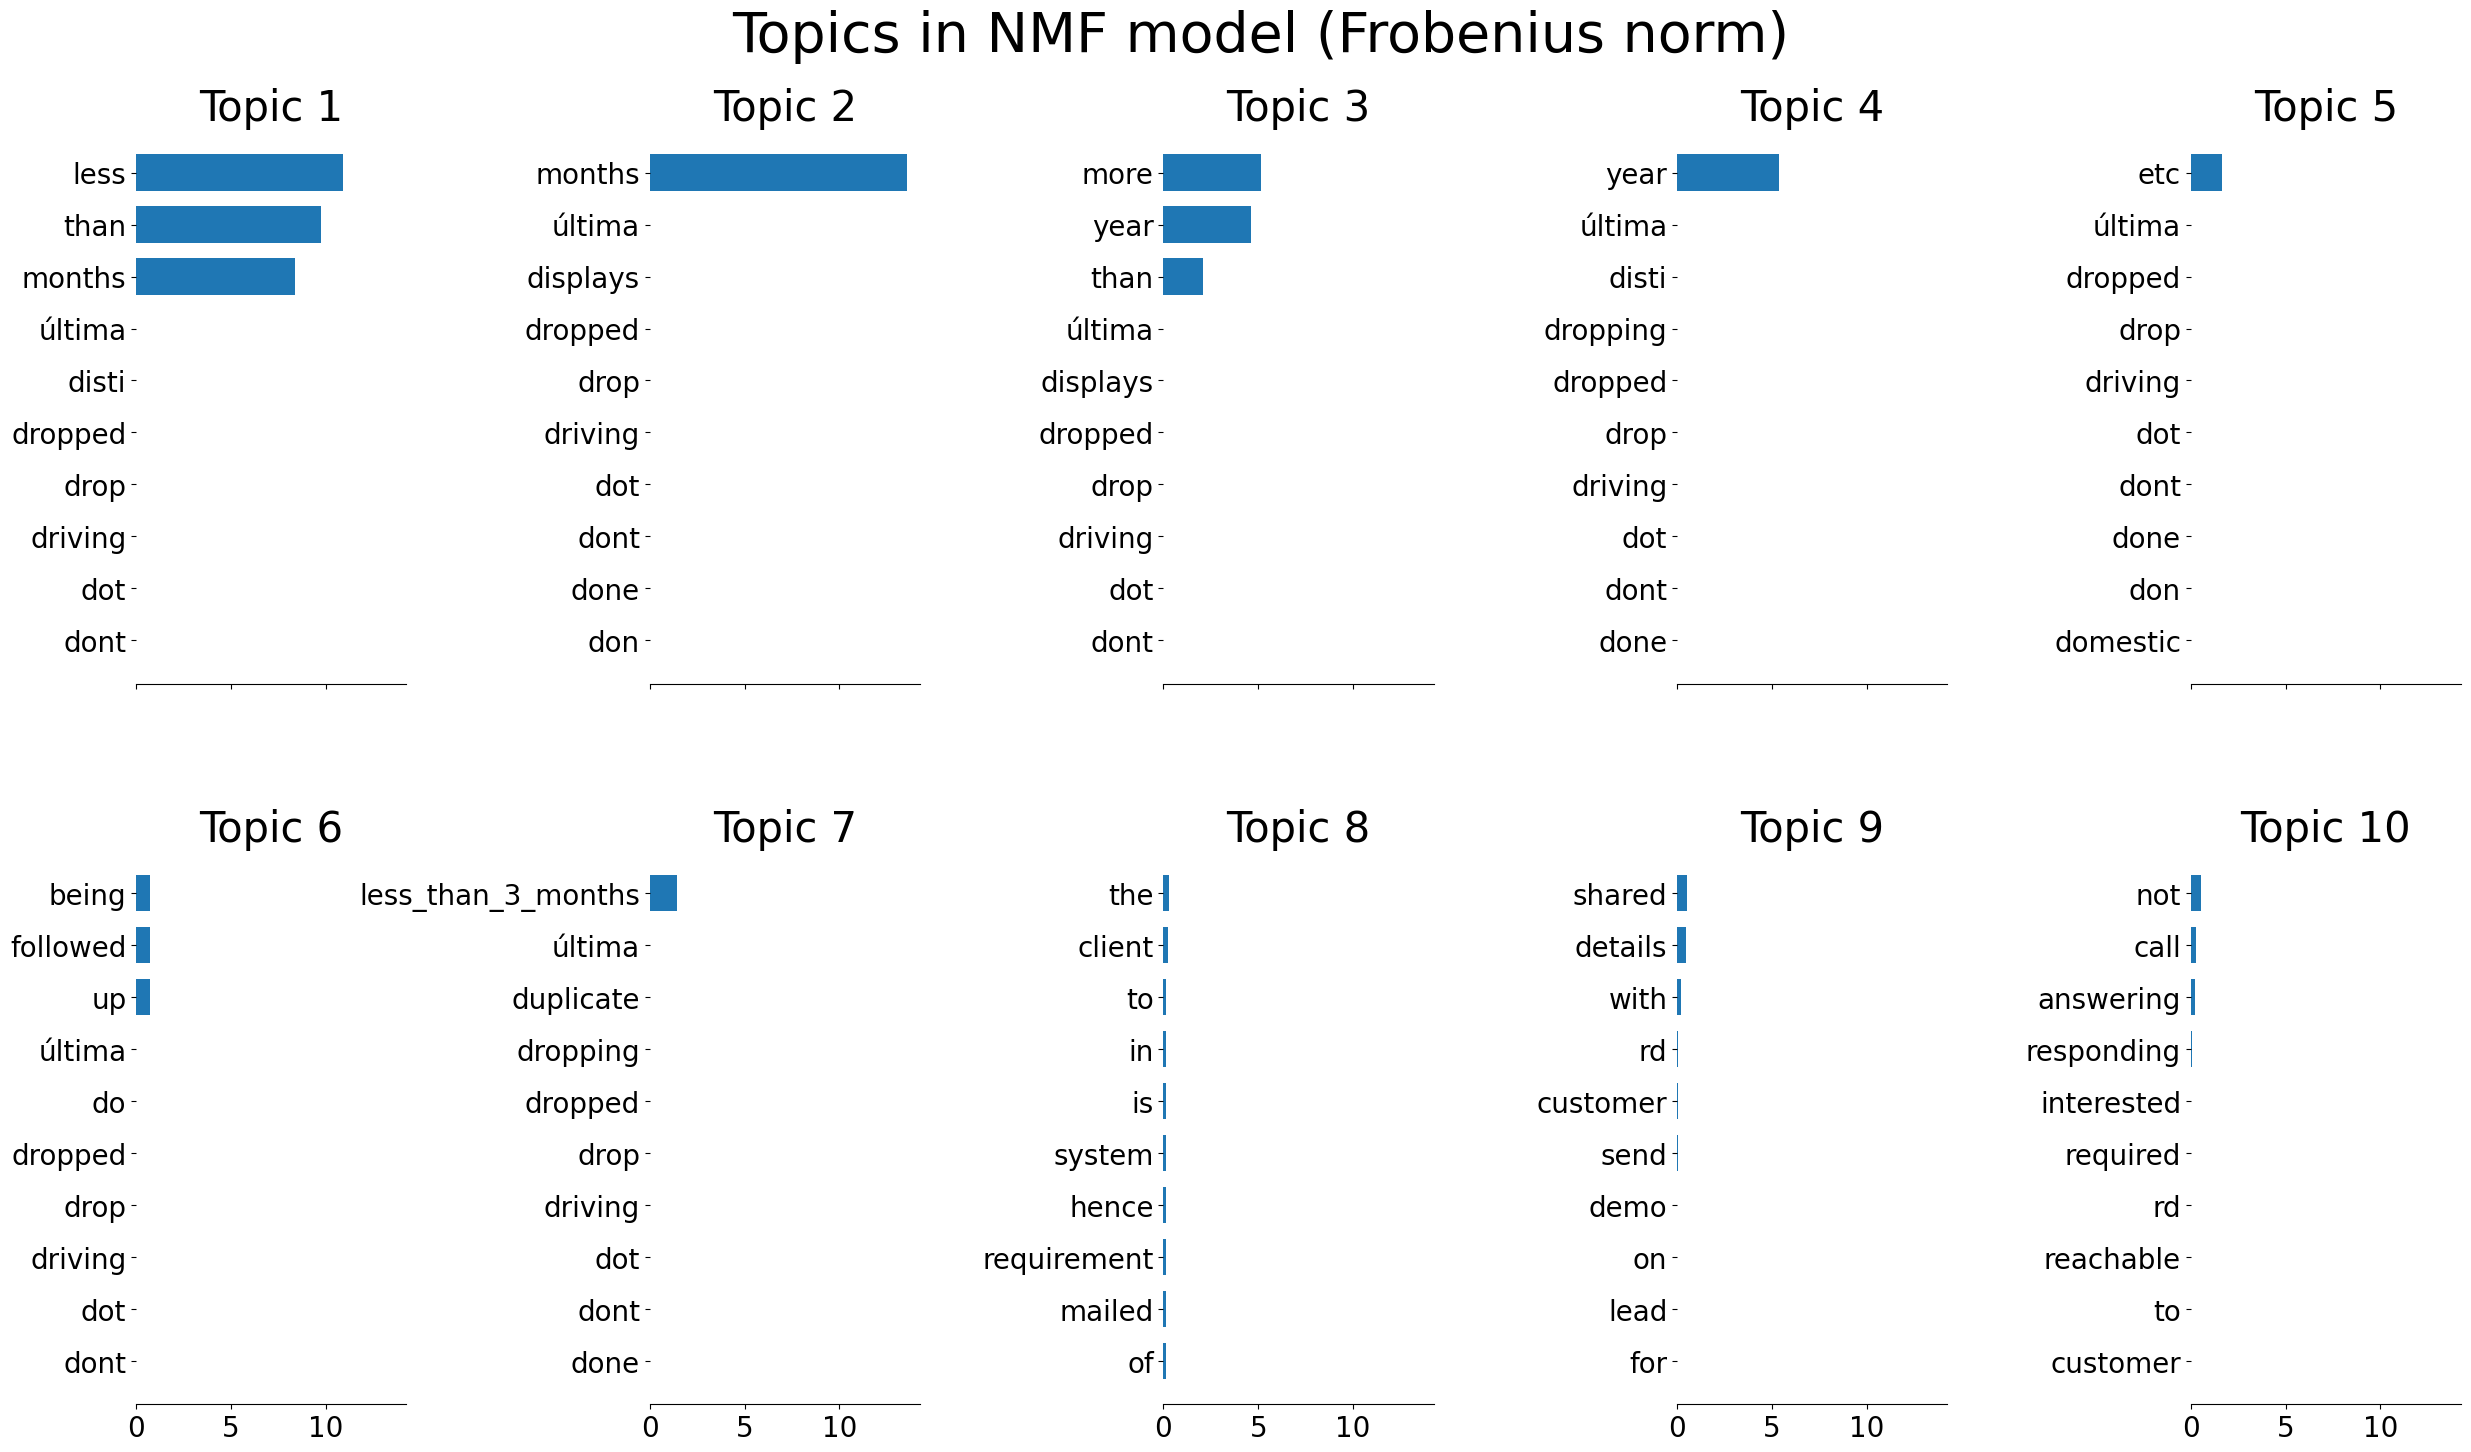

In [22]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, 10, "Topics in NMF model (Frobenius norm)"
)